In [1]:
from qick import *

from numpy.fft import fftshift
from scipy.signal import welch

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
soc = QickSoc('./test_pfb_v4.bit')
soccfg = soc

print(soccfg)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.266
	Firmware timestamp: Fri Apr 12 11:50:46 2024

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 16384 samples (2.381 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_sg_mux8_v1 - envelope memory 0 samples (0.000 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3

	8 readout channels:
	0:	axis_pfb_readout_v4 - configured by PYNQ
		fs=2457.600 MHz, decimated=38.400 MHz, 32-bit DDS, range=38.400 MHz
		maxlen 16384 accumulated, 16384 decimated (426.667 us)
		triggered by output 7, pin 4, feedback to tProc input 0
		ADC tile 2, blk 0 is 0_226, on JHC7
	1:	axis_pfb_readout_v4 - configured by PYNQ
		fs=2457.600 MHz, decimated=38.400 MHz, 32-bit DDS, range=38.400 MHz
		maxlen 16384 accumulated, 16384 decimated (426

## Frequency-multiplexed loopback
The point of the muxed generator and the PFB readout is to play and read multiple tones at the same time, as in this example.

In [3]:
#####################################
### Mux Generator and PFB Readout ###
#####################################
class PFBReadoutTest(AveragerProgram):
    def initialize(self):       
        # Declare Readouts.
        length = self.us2cycles(self.cfg['ro_length'], ro_ch=self.cfg['ro_ch'][0])
        for iCh, ch in enumerate(self.cfg['ro_ch']):
            self.declare_readout(ch     = ch,
                                 freq   = self.cfg['ro_freqs'][iCh],
                                 length = length,
                                 gen_ch = self.cfg['gen_ch'])
        
        # Declare Generators.
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=1,
                         mux_freqs = self.cfg['pulse_freqs'],
                         mux_gains = self.cfg['pulse_gains'],
                        ro_ch=self.cfg['ro_ch'][0])        
        
        # Pulse registers.
        length = self.us2cycles(self.cfg['pulse_length'], gen_ch=self.cfg['gen_ch'])
        self.set_pulse_registers(ch = self.cfg['gen_ch'], style = 'const', length=length, mask=[0,1,2,3,4,5,6,7])
        
        self.synci(200)
    
    def body(self):
        self.measure(pulse_ch        = self.cfg['gen_ch'], 
                     adcs            = self.ro_chs,
                     pins            = [0], 
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset']))
        
        self.synci(self.us2cycles(self.cfg['period']))

config={"ro_ch"       : [0,1,2,3,4,5,6,7],
        "ro_length"   : 10, # us
        "ro_freqs"    : [200,300,400,500,600,700,800,900],
        "ro_offset"   : 0,
        
        "gen_ch"      : 1,   
        "pulse_length": 6, # us
        "pulse_freqs" : [200,300,400,500,600,700,800,900],
        "pulse_gains" : [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2],
#         "pulse_gains" : [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.9],
        "reps"        : 1,
        "period"      : 20,
        "soft_avgs"   : 10
       }

prog = PFBReadoutTest(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True)

  0%|          | 0/10 [00:00<?, ?it/s]

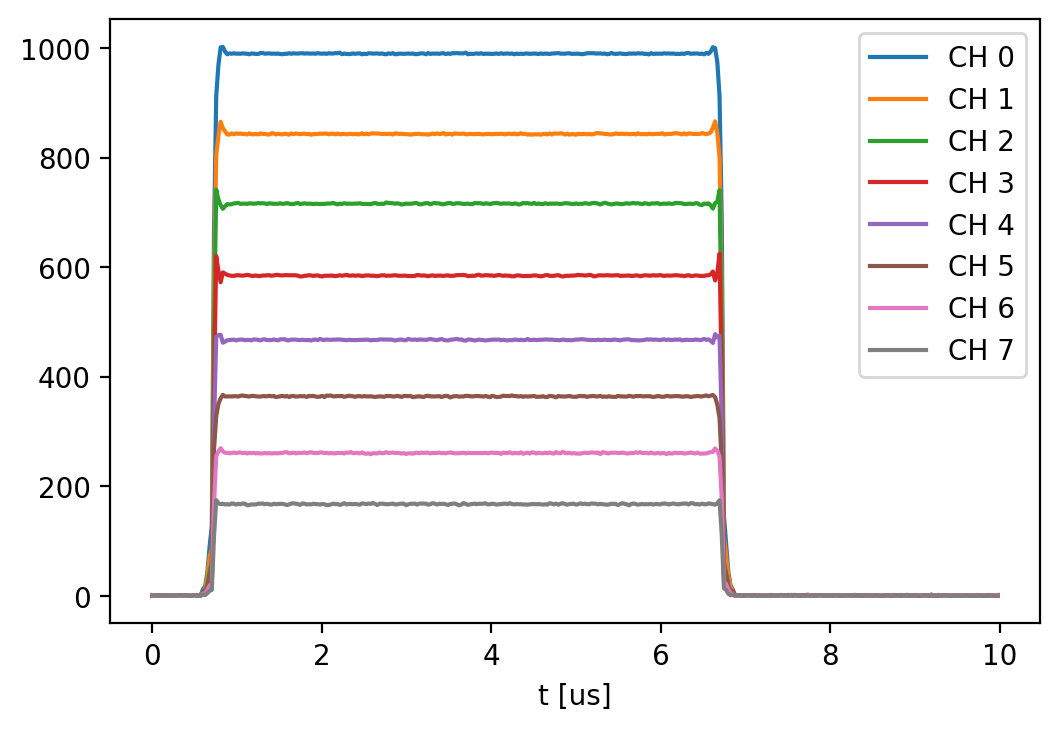

In [4]:
# Plot Captured Data.
x = prog.get_time_axis(ro_index=0) # time axis for the first declare_readout

# I/Q of channels.
yi = []
yq = []
for i in range(len(config['ro_freqs'])):
    yi.append(iq_list[i][0])
    yq.append(iq_list[i][1])

# Plot magnitude
plt.figure(dpi=200)
for i in range(len(yi)):
    plt.plot(x,np.abs(yi[i]+1j*yq[i]),label='CH {}'.format(i))
    
plt.xlabel('t [us]');
plt.legend();

In [5]:
# # Plot real part.
# plt.figure(dpi=200)
# for i in range(len(yi)):
#     plt.plot(x,yi[i],label='CH {}'.format(i))
    
# plt.xlabel('t [ns]');
# plt.title('I');
# plt.legend();

# # Plot imaginary part.
# plt.figure(dpi=200)
# for i in range(len(yq)):
#     plt.plot(x,yq[i],label='CH {}'.format(i))
    
# plt.xlabel('t [ns]');
# plt.title('Q');
# plt.legend();

## Channelizer visualization
Internally, the PFB works by dividing the ADC frequency spectrum into 64 "channels."

We can step through each of the PFB channels with downconversion disabled - we do this by setting the readout frequency to exactly the center frequency of each channel - and FFT the decimated output to map out the frequency response.

In [6]:
###############################
### Multiplexed Readout PFB ###
###############################
rocfg = soccfg['readouts'][0]
fs = rocfg['fs']/rocfg['decimation'] # total frequency span
N = rocfg['pfb_nch'] # number of PFB channels
M = rocfg['pfb_ch_offset']
fc_ch = fs/N
fs_ch = rocfg['f_dds']
print("PFB Readout Parameters:")
print(" -> fs                = {} MHz".format(fs))
print(" -> Channel Distance  = {} MHz".format(fc_ch))
print(" -> Channel Bandwidth = {} MHz".format(fs_ch))
# print("PFB Band Assignment:")
# for i in range(N):
#     fc = i*fc_ch
#     if i<M:
#         fc += fs/2
#     else:
#         fc -= fs/2
#     f0 = fc - fs_ch/2
#     f1 = fc + fs_ch/2
#     f0_flat = fc - fs_ch/4
#     f1_flat = fc + fs_ch/4
#     print("Channel {}: fc = {:>7.2f} MHz,Band = [{:>7.2f}, {:>7.2f}] MHz, Flat = [{:>7.2f}, {:>7.2f}] MHz"
#           .format(i,fc,f0,f1,f0_flat,f1_flat))

PFB Readout Parameters:
 -> fs                = 1228.8 MHz
 -> Channel Distance  = 19.2 MHz
 -> Channel Bandwidth = 38.4 MHz


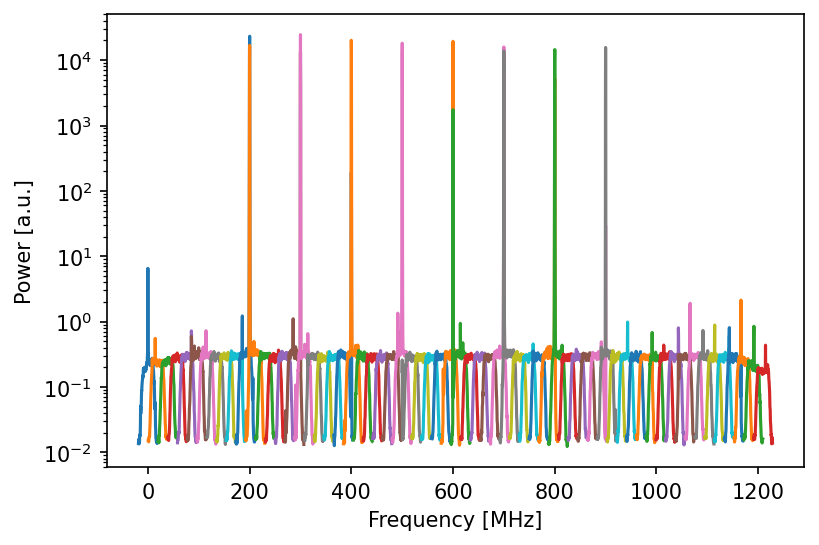

In [7]:
#################################
### PFB Channels Side-by-Side ###
#################################
class MuxReadoutTest(AveragerProgram):
    def initialize(self):        
        # Declare Generator (Mux).
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=1,
                         mux_freqs = self.cfg['pulse_freqs'],
                         mux_gains = self.cfg['pulse_gains'])
        
        # Declare Readouts.
        length = self.us2cycles(self.cfg['ro_length'],
                                ro_ch=self.cfg['ro_ch'])
        self.declare_readout(ch     = self.cfg['ro_ch'],
                            freq   = self.cfg['ro_freq'],
                            length = length)
        
        # we intentionally don't use frequency matching:
        # we want the RO freqs to be exactly at the channel centers
        # and we don't actually care if the gen freqs are matched
        
        # Pulse registers.
        length = self.us2cycles(self.cfg['pulse_length'], gen_ch=self.cfg['gen_ch'])
        self.set_pulse_registers(ch = self.cfg['gen_ch'], style = 'const', length=length, mask=[0,1,2,3,4,5,6,7])        
        
        self.synci(200)
    
    def body(self):
        self.measure(adcs = [self.cfg['ro_ch']], pins = [0], pulse_ch=self.cfg['gen_ch'], adc_trig_offset=300)

config={"ro_ch"       : 0,
        "ro_length"   : 400,
        "ro_freq"     : 1,
        
        "gen_ch"      : 1,        
        "pulse_length": 500,
        "pulse_freqs" : [200,300,400,500,600,700,800,900],
#         "pulse_gains" : [0.0]*8,
        "pulse_gains" : [0.1]*8,
#         "pulse_gains" : [0.1]+[0]*7,
        "reps"        : 1,
       }

# Frequency and amplitude vectors.
complex_iq = []
# Loop over channel centers.
foffset = 0*fs_ch/4
fc_v = np.arange(0, fs, fc_ch) + foffset
for fck in fc_v:
    # Update frequency.
    config['ro_freq'] = fck
    
    # Get data from channel.
    prog = MuxReadoutTest(soccfg, config)
    iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False, remove_offset=True)
    xi = iq_list[0][0]
    xq = iq_list[0][1]
    complex_iq.append(xi + 1j*xq)
    
fig, ax = plt.subplots(1, dpi=150);
for fck, x in zip(fc_v, complex_iq):
    fft_freqs, psd = fftshift(welch(x, fs_ch, return_onesided=False, nperseg=128, detrend=False), axes=1)
    # we drop the FFT points at the ends of the range, which are high because of the period-2 oscillation
    ax.semilogy(fft_freqs[2:-1]+fck, psd[2:-1])
#     ax.semilogy(fft_freqs+fck, psd)

ax.set_xlabel("Frequency [MHz]");
ax.set_ylabel("Power [a.u.]");   
# ax.set_xlim(150,250)

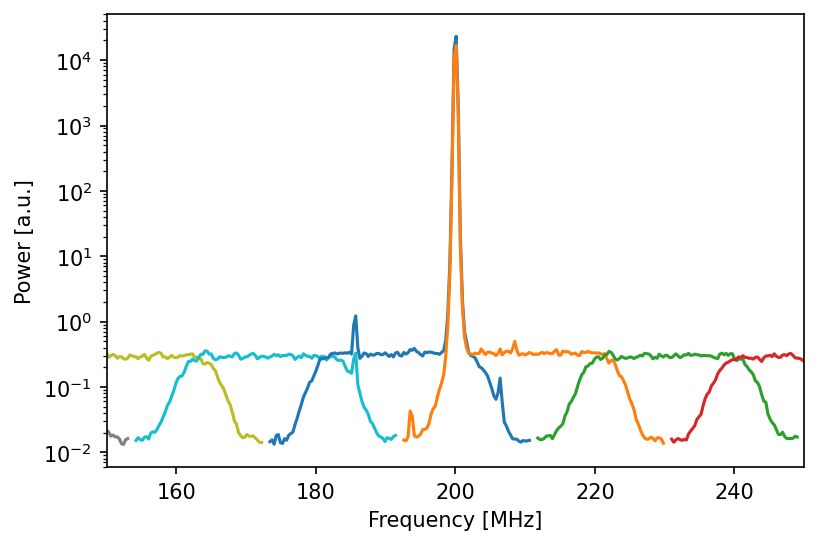

In [8]:
## Zoom in to see channel bandwidth
ax.set_xlim(150,250)

fig

### Extra: examining IQ offsets

Turn off the tones and disable offset removal, so we can look at the IQ offsets.
For the non-multiplexed readouts we just see constant -0.5-0.5j ADU DC offsets on the output after DDS downconversion and decimation.
For the PFB readouts we see something more complicated:
* Every PFB channel has a -0.5-0.5j ADU DC offset on the output after DDS downconversion.
* Every PFB channel also has a spurious signal which seems to exist at the channelizer output (so, this signal gets downconverted). This also has amplitude -0.5-0.5j, but is at DC for even-numbered channels and at fs_ch/2 for odd-numbered channels, in other words it's a -0.5-0.5j ADU DC offset for even and alternates between 0.5+0.5j and -0.5-0.5j ADU on alternating samples for odd.
The output DC offset is easy to subtract out. The spurious signal can only be subtracted out if it's at DC after downconversion; otherwise it's a noise source (but hopefully not large enough to matter).

By default, the `remove_offset` option subtracts out these offsets.

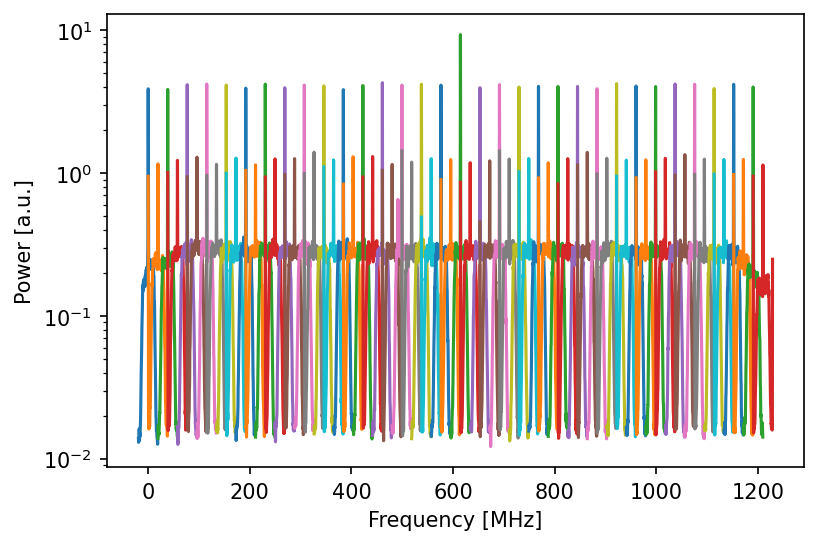

In [9]:
config={"ro_ch"       : 0,
        "ro_length"   : 400,
        "ro_freq"     : 1,
        
        "gen_ch"      : 1,        
        "pulse_length": 500,
        "pulse_freqs" : [0.0]*8,
        "pulse_gains" : [0.0]*8,
        "reps"        : 1,
       }

# Frequency and amplitude vectors.
complex_iq = []
# Loop over channel centers.
foffset = 0*fs_ch/4
fc_v = np.arange(0, fs, fc_ch) + foffset
for fck in fc_v:
    # Update frequency.
    config['ro_freq'] = fck
    
    # Get data from channel.
    prog = MuxReadoutTest(soccfg, config)
    iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False, remove_offset=False)
    xi = iq_list[0][0]
    xq = iq_list[0][1]
    complex_iq.append(xi + 1j*xq)
    
fig, ax = plt.subplots(1, dpi=150);
for fck, x in zip(fc_v, complex_iq):
    fft_freqs, psd = fftshift(welch(x, fs_ch, return_onesided=False, nperseg=128, detrend=False), axes=1)
    ax.semilogy(fft_freqs+fck, psd)

ax.set_xlabel("Frequency [MHz]");
ax.set_ylabel("Power [a.u.]");   
# ax.set_xlim(150,250)

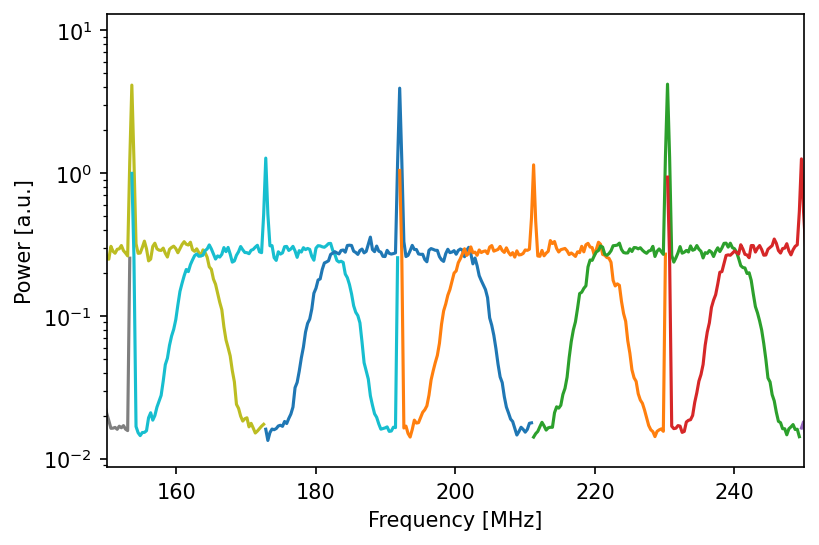

In [10]:
## Zoom in: all channels have spikes at DC, odd-numbered channels also have spikes at fs_ch/2
ax.set_xlim(150,250)

fig

In [11]:
# compute the means of even and odd samples for every channel
# even channels have a DC offset at roughly -1-1j
# odd channels alternate between 0 and -1-1j
for x in complex_iq:
    print(x.reshape(-1,2).mean(axis=0))

[0.75546875-0.91393229j 0.76119792-0.90742187j]
[ 0.00911458-0.00716146j -0.91523437-0.91510417j]
[-0.90299479-0.88320312j -0.92109375-0.8796875j ]
[-0.96354167-0.90807292j  0.0328125 -0.01679687j]
[-0.96549479-0.90429688j -0.96445313-0.90208333j]
[-0.89466146-0.95520833j -0.04361979+0.01197917j]
[-0.91966146-0.94934896j -0.91809896-0.95820312j]
[-0.009375 +0.03932292j -0.9109375-0.90130208j]
[-0.91536458-0.93802083j -0.92083333-0.95807292j]
[-0.0375    +0.025j      -0.92096354-0.96354167j]
[-0.84661458-0.94348958j -0.85729167-0.95690104j]
[-0.91510417-0.93658854j  0.02604167+0.04231771j]
[-0.91940104-0.95690104j -0.90911458-0.95143229j]
[-0.85976562-0.99231771j -0.07473958+0.02682292j]
[-0.88033854-0.94023437j -0.86835937-0.93802083j]
[-0.88658854-0.98307292j -0.04648438+0.02526042j]
[-0.94934896-0.91809896j -0.93893229-0.90546875j]
[-0.05390625+0.00208333j -0.97317708-0.95208333j]
[-0.94192708-0.90091146j -0.94661458-0.91796875j]
[-0.96263021-0.95546875j  0.04322917+0.01588542j]
[-0.

If you shift the readout frequencies a bit, you can see the two sets of offsets.

(150.0, 250.0)

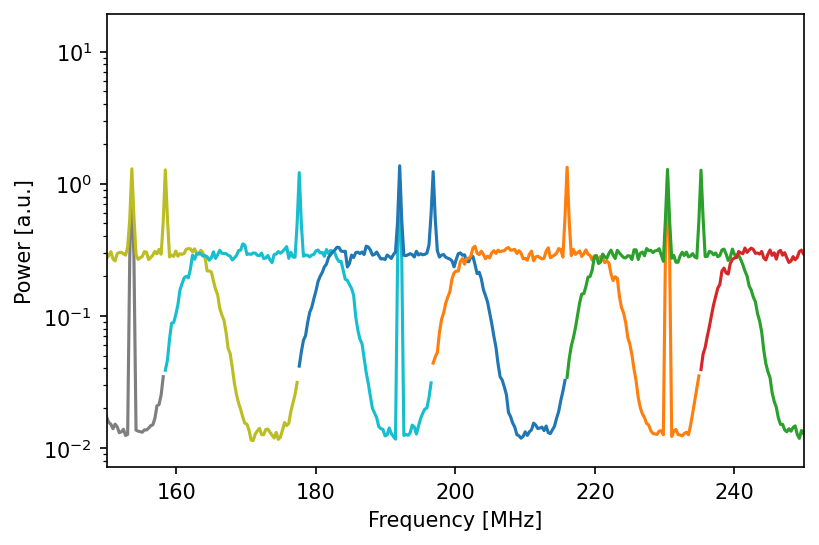

In [13]:
config={"ro_ch"       : 0,
        "ro_length"   : 400,
        "ro_freq"     : 1,
        
        "gen_ch"      : 1,        
        "pulse_length": 500,
        "pulse_freqs" : [0.0]*8,
        "pulse_gains" : [0.0]*8,
        "reps"        : 1,
       }

# Frequency and amplitude vectors.
complex_iq = []
# Loop over channel centers.
foffset = 0.5*fs_ch/4
fc_v = np.arange(0, fs, fc_ch) + foffset
for fck in fc_v:
    # Update frequency.
    config['ro_freq'] = fck
    
    # Get data from channel.
    prog = MuxReadoutTest(soccfg, config)
    iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False, remove_offset=False)
    xi = iq_list[0][0]
    xq = iq_list[0][1]
    complex_iq.append(xi + 1j*xq)
    
fig, ax = plt.subplots(1, dpi=150);
for fck, x in zip(fc_v, complex_iq):
    fft_freqs, psd = fftshift(welch(x, fs_ch, return_onesided=False, nperseg=128, detrend=False), axes=1)
    ax.semilogy(fft_freqs+fck, psd)

ax.set_xlabel("Frequency [MHz]");
ax.set_ylabel("Power [a.u.]");   
ax.set_xlim(150,250)